## LOAD DATASETS

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as scipy_stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Load all datasets
df_iowait = pd.read_csv("cpu_iowait.csv")
df_cpu_irq = pd.read_csv("cpu_irq.csv")
df_system_msec = pd.read_csv("cpu_system_msec.csv")
df_user_msec = pd.read_csv("cpu_user_msec.csv")
df_cpu_util = pd.read_csv("cpu_util_per.csv")

df_baseline_iowait = pd.read_csv("../../baseline/cpu related/cpu_iowait.csv")
df_baseline_irq = pd.read_csv("../../baseline/cpu related/cpu_irq.csv")
df_baseline_system_msec = pd.read_csv("../../baseline/cpu related/cpu_system_msec.csv")
df_baseline_user_msec = pd.read_csv("../../baseline/cpu related/cpu_user_msec.csv")
df_baseline_util_per = pd.read_csv("../../baseline/cpu related/cpu_util_per.csv")

# Add source labels
df_iowait["source"] = "CPU STRESS"
df_cpu_irq["source"] = "CPU STRESS"
df_system_msec["source"] = "CPU STRESS"
df_user_msec["source"] = "CPU STRESS"
df_cpu_util["source"] = "CPU STRESS"

df_baseline_iowait["source"] = "BASELINE"
df_baseline_irq["source"] = "BASELINE"
df_baseline_system_msec["source"] = "BASELINE"
df_baseline_user_msec["source"] = "BASELINE"
df_baseline_util_per["source"] = "BASELINE"

# Convert to datetime
df_iowait["Time"] = pd.to_datetime(df_iowait["Time"])
df_cpu_irq["Time"] = pd.to_datetime(df_cpu_irq["Time"])
df_system_msec["Time"] = pd.to_datetime(df_system_msec["Time"])
df_user_msec["Time"] = pd.to_datetime(df_user_msec["Time"])
df_cpu_util["Time"] = pd.to_datetime(df_cpu_util["Time"])

df_baseline_iowait["Time"] = pd.to_datetime(df_baseline_iowait["Time"])
df_baseline_irq["Time"] = pd.to_datetime(df_baseline_irq["Time"])
df_baseline_system_msec["Time"] = pd.to_datetime(df_baseline_system_msec["Time"]) 
df_baseline_user_msec["Time"] = pd.to_datetime(df_baseline_user_msec["Time"])
df_baseline_util_per["Time"] = pd.to_datetime(df_baseline_util_per["Time"])

delay = 30
duration = 50

# Synchronize test datasets with baseline timeline
time_offset = df_baseline_iowait["Time"].min() - df_iowait["Time"].min()
df_iowait["Time"] += time_offset
df_cpu_irq["Time"] += time_offset
df_system_msec["Time"] += time_offset
df_user_msec["Time"] += time_offset
df_cpu_util["Time"] += time_offset

# Convert timeline to minutes 
all_dfs = [
    df_iowait, df_cpu_irq, df_system_msec, df_user_msec, df_cpu_util,
    df_baseline_iowait, df_baseline_irq, df_baseline_system_msec, 
    df_baseline_user_msec, df_baseline_util_per
]

for df in all_dfs:
    df["Minutes"] = (df["Time"] - df["Time"].min()).dt.total_seconds() / 60

# ORIGINAL DATASETS DICTIONARY 
original_datasets = {
    'IOWait': {'cpu_stress': df_iowait, 'baseline': df_baseline_iowait},
    'IRQ': {'cpu_stress': df_cpu_irq, 'baseline': df_baseline_irq},
    'System': {'cpu_stress': df_system_msec, 'baseline': df_baseline_system_msec},
    'User': {'cpu_stress': df_user_msec, 'baseline': df_baseline_user_msec},
    'Utilization': {'cpu_stress': df_cpu_util, 'baseline': df_baseline_util_per}
}

## TUNA AND FEATURE ENGINEERING

In [ ]:
def apply_tuna(df):

    df_result = df.copy()
    
    cpu_columns = [col for col in df.columns if col.startswith('cpu') and col not in ['cpu 8', 'cpu 9']]
    
    # per feature outlier detection
    feature_outlier_stats = {}
    total_outliers_detected = 0
    
    for cpu_col in cpu_columns:
        print(f"  🔍 Processing {cpu_col}...")
        
        outliers_detected = 0
        
        if 'Time' in df_result.index.names:
            # Group by 2-minute windows
            grouped = df_result.groupby(pd.Grouper(freq='2min'))
            
            for name, group in grouped:
                if len(group) < 2:
                    continue
                
                values = group[cpu_col].values
                if len(values) > 1 and np.mean(values) > 0:
                    # RELATIVE RANGE FORMULA 
                    relative_range = (np.max(values) - np.min(values)) / np.mean(values)

                    if relative_range > 0.30:                        
                        correction_factor = 0.50  # 50% penalty
                        df_result.loc[group.index, cpu_col] *= correction_factor
                        outliers_detected += 1
        
        feature_outlier_stats[cpu_col] = {
            'outliers_detected': outliers_detected,
            'relative_threshold': 0.30,
            'correction_factor': 0.50
        }
        
        total_outliers_detected += outliers_detected
        print(f"    ✅ {cpu_col}: {outliers_detected} unstable periods corrected")
    
    # per feature noise modeling
    noise_stats = {}
    successful_models = 0
    total_noise_reduction = 0.0
    
    for cpu_col in cpu_columns:        
        try:

                
            # feature engineering per noise modeling (used for the training the model)
            feature_df = df_result.copy()
            
            # statistical features
            feature_df[f'{cpu_col}_lag1'] = feature_df[cpu_col].shift(1)
            feature_df[f'{cpu_col}_lag2'] = feature_df[cpu_col].shift(2)
            feature_df[f'{cpu_col}_rolling_mean_5'] = feature_df[cpu_col].rolling(5).mean()
            feature_df[f'{cpu_col}_rolling_std_5'] = feature_df[cpu_col].rolling(5).std()
                
            # Interaction with other CPU cores
            other_cpus = [col for col in cpu_columns if col != cpu_col]
            if other_cpus:
                feature_df[f'{cpu_col}_vs_others_mean'] = feature_df[cpu_col] / (feature_df[other_cpus].mean(axis=1) + 0.001)
                feature_df[f'{cpu_col}_vs_others_max'] = feature_df[cpu_col] / (feature_df[other_cpus].max(axis=1) + 0.001)
                
            # Select feature columns for this CPU
            base_features = [col for col in feature_df.columns if col.startswith(f'{cpu_col}_')]
            other_cpu_features = [col for col in other_cpus[:3]]  # Limit to 3 other CPUs to avoid overfitting
            
            feature_columns = base_features + other_cpu_features
            feature_columns = [col for col in feature_columns if col in feature_df.columns]
                
            # Prepare target (percent error from mean)
            target_mean = feature_df[cpu_col].mean()
            if target_mean > 0:
                feature_df['target'] = (feature_df[cpu_col] / target_mean) - 1
                    
                # Clean data
                clean_data = feature_df[feature_columns + ['target']].dropna()
                    

                X = clean_data[feature_columns]
                y = clean_data['target']
                        
                # Scale features
                scaler = StandardScaler()
                X_scaled = scaler.fit_transform(X)
                        
                # Train Random Forest
                model = RandomForestRegressor(
                    n_estimators=100,
                    max_depth=10,  # Prevent overfitting
                    random_state=42,
                    n_jobs=-1
                )
                model.fit(X_scaled, y)
                        
                # Predict noise corrections
                feature_matrix = feature_df[feature_columns].fillna(method='ffill').fillna(method='bfill').fillna(0)
                X_pred_scaled = scaler.transform(feature_matrix)
                predicted_error = model.predict(X_pred_scaled)
                    
                # Apply noise correction
                original_std = df_result[cpu_col].std()
                corrected_values = df_result[cpu_col] / (predicted_error * 0.5 + 1)
                    
                # Blend 50% original + 50% corrected
                df_result[cpu_col] = 0.5 * df_result[cpu_col] + 0.5 * corrected_values
                
                cleaned_std = df_result[cpu_col].std()
                noise_reduction = ((original_std - cleaned_std) / original_std) * 100 if original_std > 0 else 0
                
                noise_stats[cpu_col] = {
                    'noise_reduction_percent': noise_reduction,
                    'features_used': len(feature_columns),
                    'model_score': model.score(X_scaled, y),
                    'samples_used': len(clean_data)
                }
                    
                successful_models += 1
                total_noise_reduction += noise_reduction
                
                print(f"    ✅ {cpu_col}: {noise_reduction:.1f}% noise reduction, R² = {model.score(X_scaled, y):.3f}")

            else:
                noise_stats[cpu_col] = {'status': 'zero_mean_target'}                
        except Exception as e:
            noise_stats[cpu_col] = {'status': 'error', 'message': str(e)}
    
    # Add Total CPU after TUNA cleaning
    df_result['Total_CPU_TUNA'] = df_result[cpu_columns].sum(axis=1)
    
    # Calculate average noise reduction
    avg_noise_reduction = total_noise_reduction / max(1, successful_models)
    
    outlier_stats = {
        'per_feature_outliers': feature_outlier_stats,
        'per_feature_noise': noise_stats,
        '_summary': {
            'total_features_processed': len(cpu_columns),
            'total_outliers': total_outliers_detected,
            'successful_noise_models': successful_models,
            'method': 'Enhanced-TUNA-Per-Feature',
            'relative_threshold': 0.30,
            'time_window': '2min',
            'correction_penalty': 0.25,
            'noise_blending': '50% original + 50% corrected',
            'noise_reduction': avg_noise_reduction
        }
    }
    
    return df_result, outlier_stats


def add_trend_features(df_tuna_cleaned):
    df_features = df_tuna_cleaned.copy()
    cpu_columns = [col for col in df_features.columns if col.startswith('cpu') and col not in ['cpu 8', 'cpu 9']]
    
    # Rolling statistics with multiple windows
    print("  🕒 Adding temporal trend features...")
    for window in [3, 5, 10, 15]:
        for cpu_col in cpu_columns + ['Total_CPU_TUNA']:
            # Trend indicators
            df_features[f'{cpu_col}_trend_{window}'] = df_features[cpu_col].rolling(window).apply(
                lambda x: np.polyfit(range(len(x)), x, 1)[0] if len(x) == window else np.nan
            )
            
            # Momentum indicators
            df_features[f'{cpu_col}_momentum_{window}'] = df_features[cpu_col] - df_features[cpu_col].shift(window)
            
            # Volatility indicators
            df_features[f'{cpu_col}_volatility_{window}'] = df_features[cpu_col].rolling(window).std()
            
            # Rate of change
            df_features[f'{cpu_col}_roc_{window}'] = df_features[cpu_col].pct_change(window)
    
    # statistical features
    for cpu_col in cpu_columns + ['Total_CPU_TUNA']:
        # Z-score 
        rolling_mean = df_features[cpu_col].rolling(10).mean()
        rolling_std = df_features[cpu_col].rolling(10).std()
        df_features[f'{cpu_col}_zscore'] = (df_features[cpu_col] - rolling_mean) / (rolling_std + 0.001)
        
        # Percentile position within recent window
        df_features[f'{cpu_col}_percentile_rank'] = df_features[cpu_col].rolling(20).rank(pct=True)
        
        # Acceleration 
        first_diff = df_features[cpu_col].diff()
        df_features[f'{cpu_col}_acceleration'] = first_diff.diff()
    
    # Cross-feature relationships
    cpu_values = df_features[cpu_columns]
    df_features['CPU_load_balance'] = cpu_values.std(axis=1) / (cpu_values.mean(axis=1) + 0.001)
    df_features['CPU_max_min_ratio'] = cpu_values.max(axis=1) / (cpu_values.min(axis=1) + 0.001)
    df_features['Active_cores_count'] = (cpu_values > cpu_values.mean(axis=1).values.reshape(-1, 1)).sum(axis=1)
    
    original_cols = len(df_tuna_cleaned.columns)
    new_cols = len(df_features.columns)
    added_features = new_cols - original_cols
        
    return df_features


# APPLY TUNA 
datasets_clean = {}
all_outlier_stats = {}

print(f"\n{'='*80}")
print("APPLYING TUNA TO ALL DATASETS")
print(f"{'='*80}")

for dataset_name, dataset_pair in original_datasets.items():
    print(f"\n📊 Processing {dataset_name}...")
    
    datasets_clean[dataset_name] = {}
    all_outlier_stats[dataset_name] = {}
    
    for source_type, df in dataset_pair.items():
        print(f"  🔍 {source_type.upper().replace('_', ' ')}:")
        
        # Apply eTUNA
        df_clean, stats = apply_tuna(df)
        
        # Add trend feature engineering 
        df_with_features = add_trend_features(df_clean)
        
        datasets_clean[dataset_name][source_type] = df_with_features
        all_outlier_stats[dataset_name][source_type] = stats
        
        total_outliers = stats['_summary']['total_outliers']
        noise_reduction = stats['_summary']['noise_reduction']
        method = stats['_summary']['method']



APPLYING TUNA TO ALL DATASETS

📊 Processing IOWait...
  🔍 CPU STRESS:
  🔍 Processing cpu 0...
    ✅ cpu 0: 0 unstable periods corrected
  🔍 Processing cpu 1...
    ✅ cpu 1: 0 unstable periods corrected
  🔍 Processing cpu 2...
    ✅ cpu 2: 0 unstable periods corrected
  🔍 Processing cpu 3...
    ✅ cpu 3: 0 unstable periods corrected
  🔍 Processing cpu 4...
    ✅ cpu 4: 0 unstable periods corrected
  🔍 Processing cpu 5...
    ✅ cpu 5: 0 unstable periods corrected
  🔍 Processing cpu 6...
    ✅ cpu 6: 0 unstable periods corrected
  🔍 Processing cpu 7...
    ✅ cpu 7: 0 unstable periods corrected
    ✅ cpu 0: 44.2% noise reduction, R² = 0.976
    ✅ cpu 1: 29.5% noise reduction, R² = 1.000
    ✅ cpu 2: 34.7% noise reduction, R² = 0.993
    ✅ cpu 3: 39.9% noise reduction, R² = 0.990
    ✅ cpu 4: 24.3% noise reduction, R² = 0.999
    ✅ cpu 5: 26.5% noise reduction, R² = 0.999
    ✅ cpu 6: 32.1% noise reduction, R² = 0.992
    ✅ cpu 7: 31.5% noise reduction, R² = 0.999
  🕒 Adding temporal trend

## PLOTTING


COMPREHENSIVE CPU STRESS ANALYSIS - ENHANCED TUNA

🔄 Analyzing IOWait...

📊 Plotting Enhanced TUNA cleaned data for IOWait...


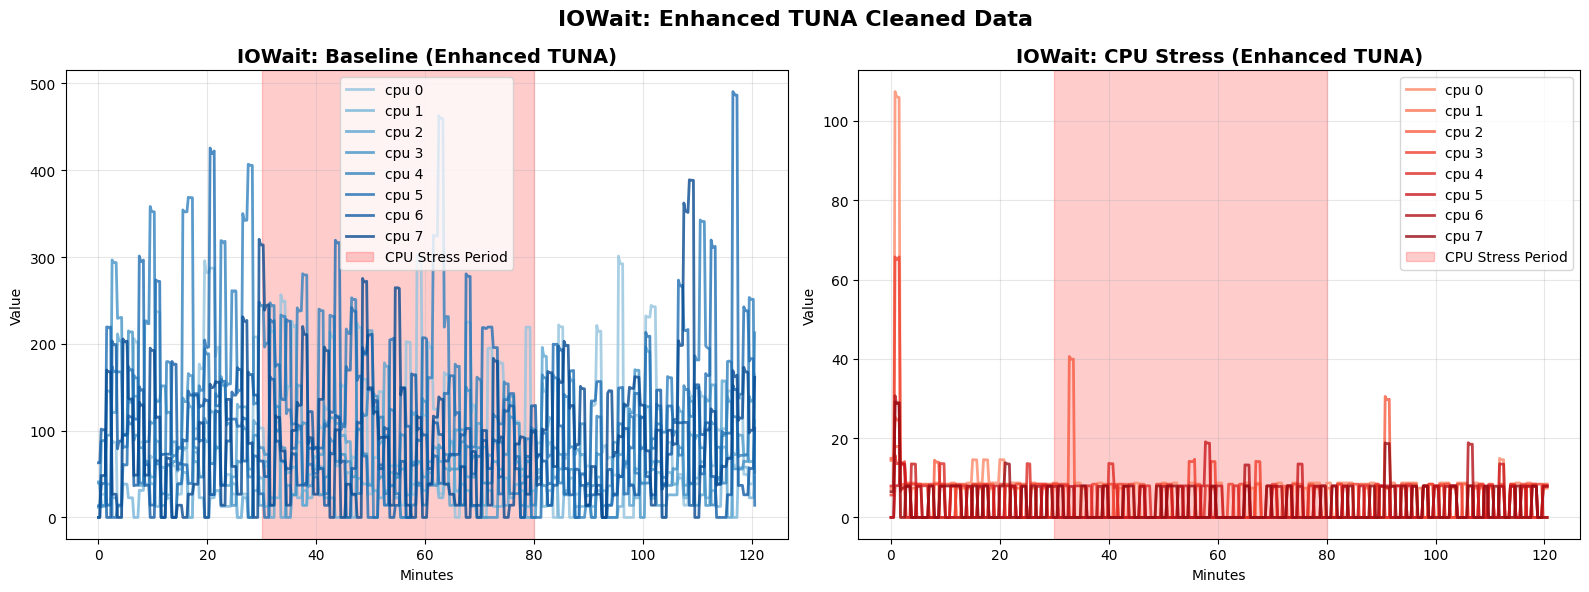

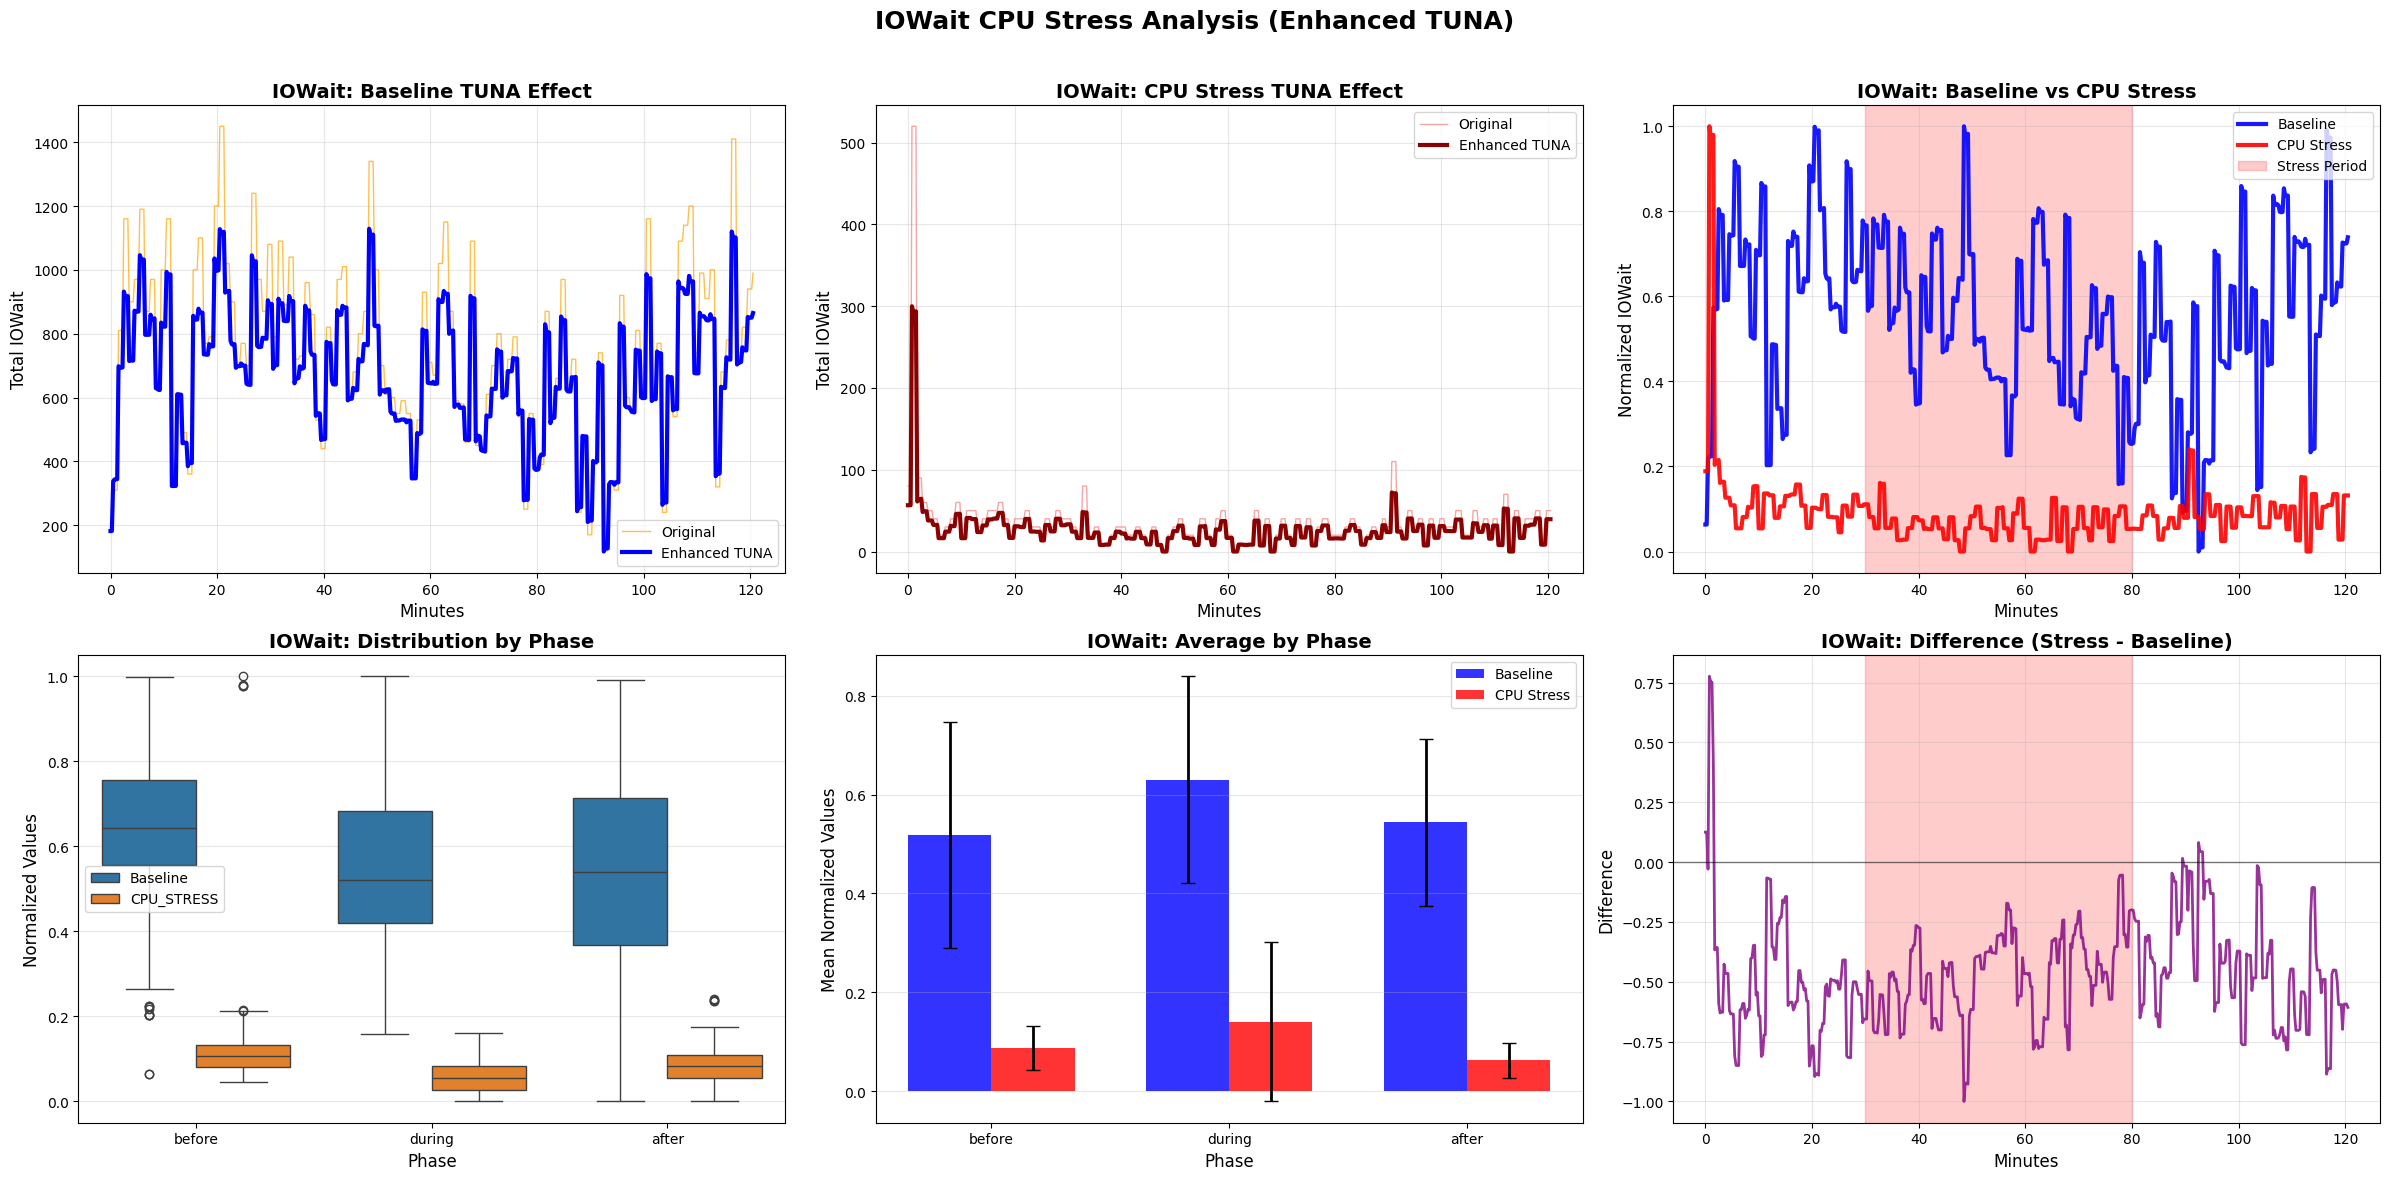

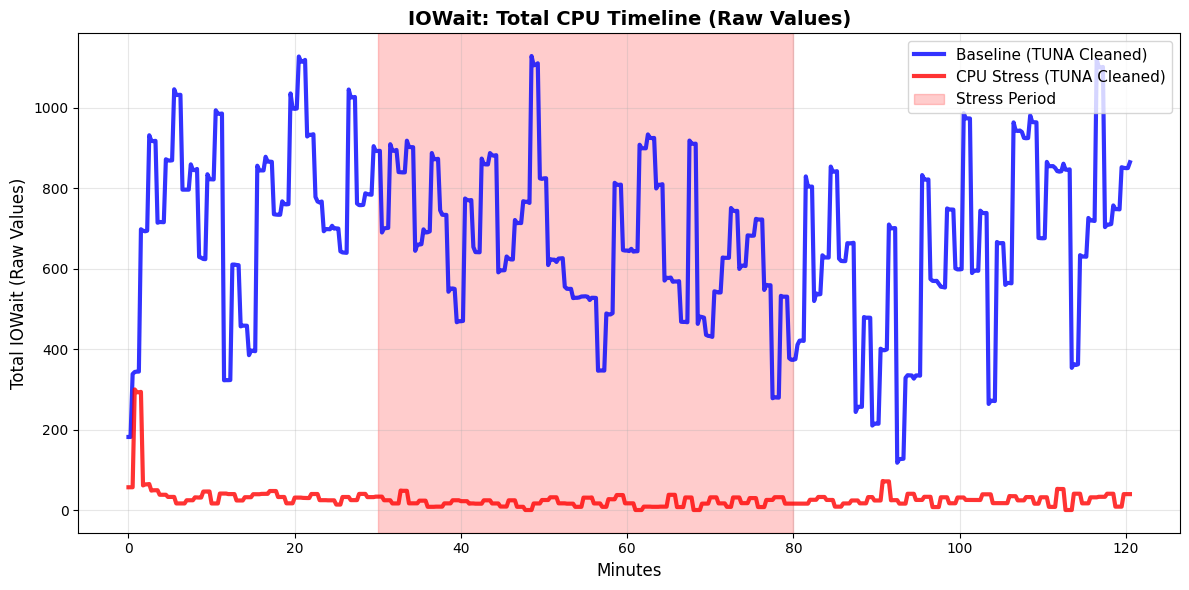


📊 IOWait - Cumulative CPU Summary:
  🔵 Baseline Mean: 680.29
  🔴 Stress Mean: 27.09
  📊 Difference: -653.20 (-96.0%)

IOWAIT - ENHANCED TUNA ANALYSIS RESULTS

🔧 ENHANCED TUNA CLEANING SUMMARY:
  CPU STRESS: 0 unstable periods, 32.8% noise reduction
  BASELINE:   0 unstable periods, 26.8% noise reduction
  METHOD:     Enhanced-TUNA-Per-Feature
  FEATURES:   8 CPU features processed
  MODELS:     8 successful noise models

📊 BASELINE STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.5180  0.2285  0.0000  0.9912
before  0.6302  0.2091  0.0634  0.9988
during  0.5435  0.1695  0.1586  1.0000

📊 CPU STRESS STATISTICS BY PHASE:
          mean     std    min     max
phase                                
after   0.0871  0.0441  0.000  0.2406
before  0.1409  0.1616  0.045  1.0000
during  0.0628  0.0354  0.000  0.1614

🔬 STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t= 20.28, p=  0.0000 (✅ SIGNIFICANT)
  DURING  : t= 39.36, p=  0.0000 (✅ SI

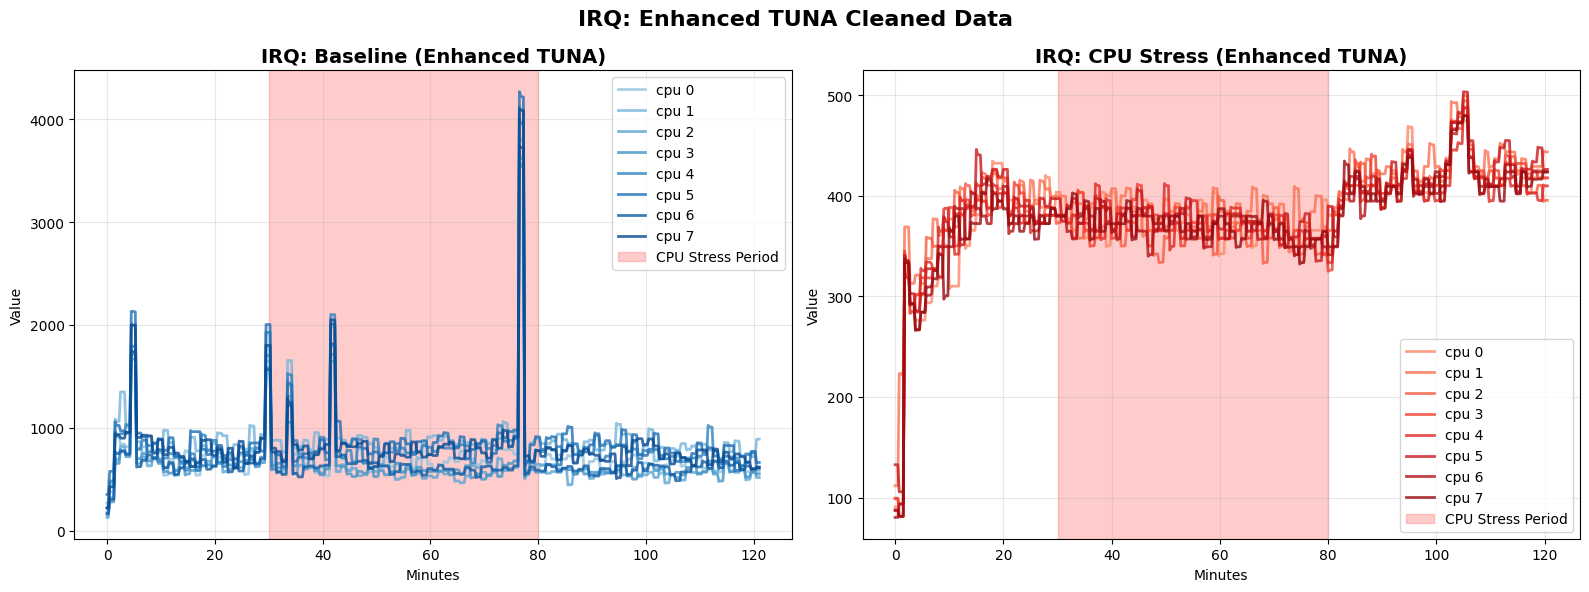

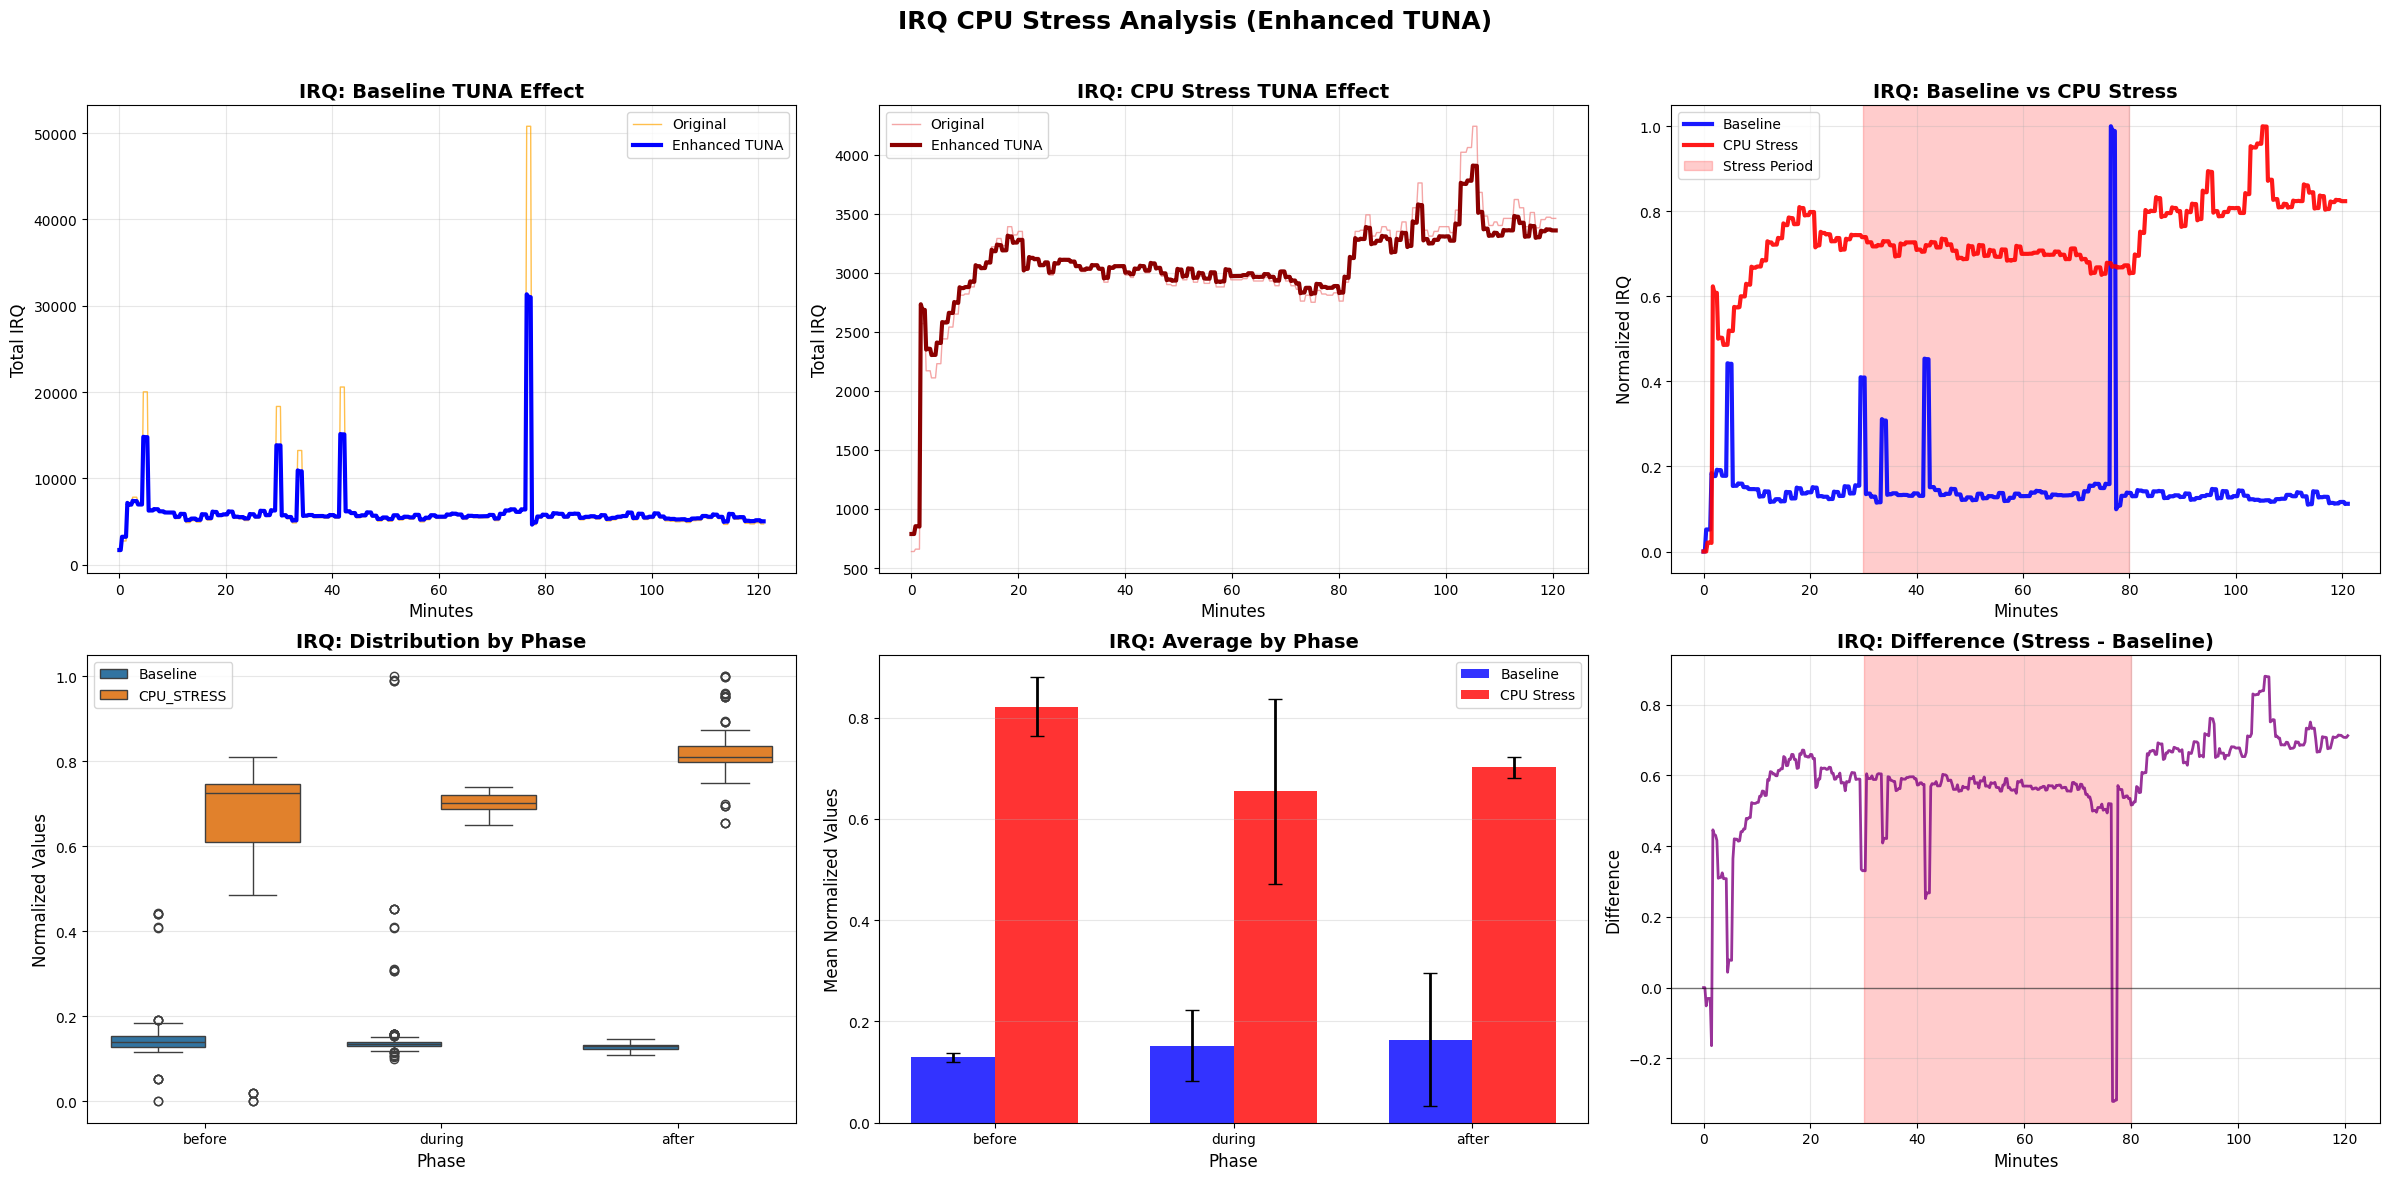

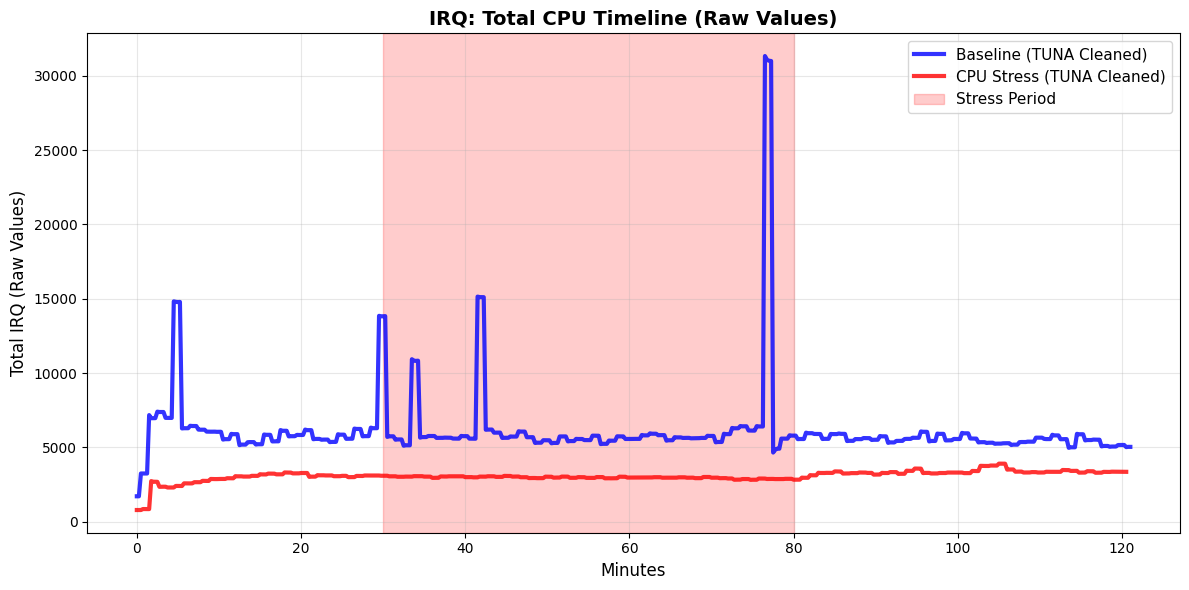


📊 IRQ - Cumulative CPU Summary:
  🔵 Baseline Mean: 6131.12
  🔴 Stress Mean: 3065.74
  📊 Difference: -3065.38 (-50.0%)

IRQ - ENHANCED TUNA ANALYSIS RESULTS

🔧 ENHANCED TUNA CLEANING SUMMARY:
  CPU STRESS: 0 unstable periods, 17.4% noise reduction
  BASELINE:   0 unstable periods, 41.1% noise reduction
  METHOD:     Enhanced-TUNA-Per-Feature
  FEATURES:   8 CPU features processed
  MODELS:     8 successful noise models

📊 BASELINE STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.1290  0.0092  0.1101  0.1472
before  0.1524  0.0709  0.0000  0.4427
during  0.1638  0.1317  0.0994  1.0000

📊 CPU STRESS STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.8212  0.0583  0.6550  1.0000
before  0.6544  0.1824  0.0000  0.8099
during  0.7020  0.0206  0.6506  0.7395

🔬 STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t=-28.09, p=  0.0000 (✅ SIGNIFICANT)
  DURING  : t=-57.25, p=  0.0000 (✅

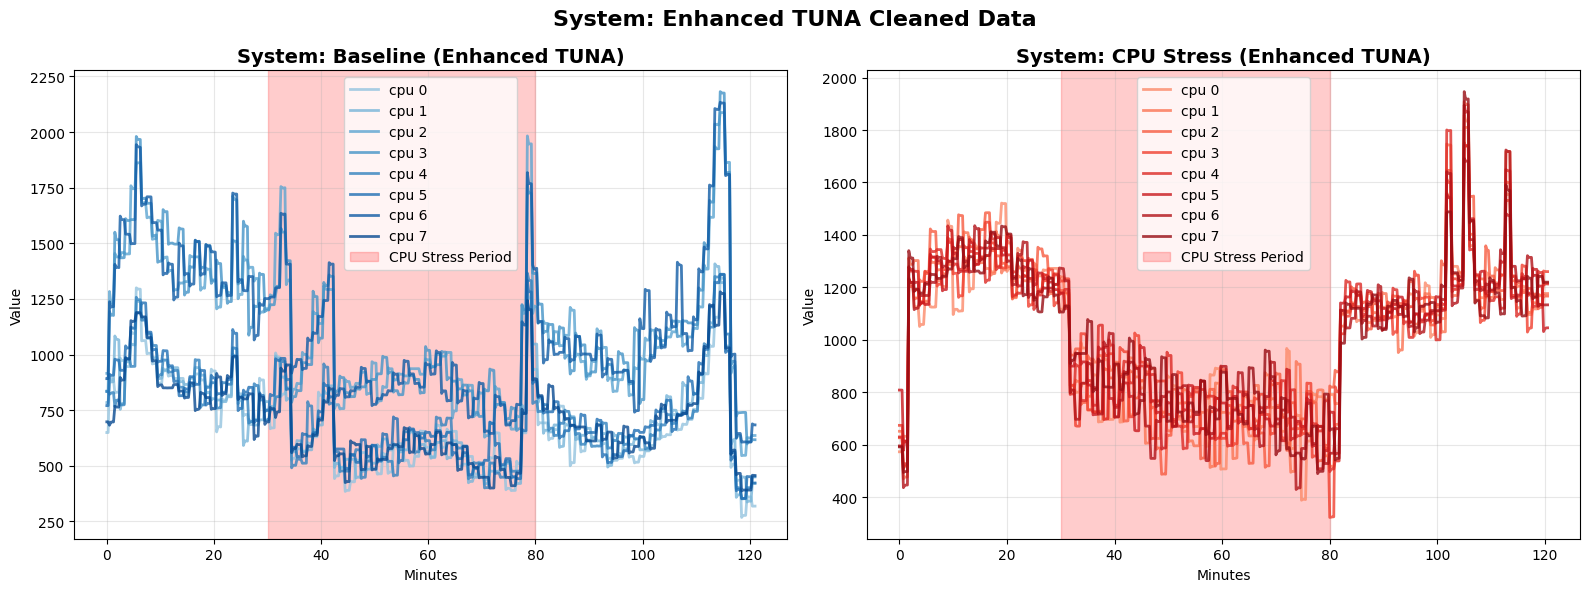

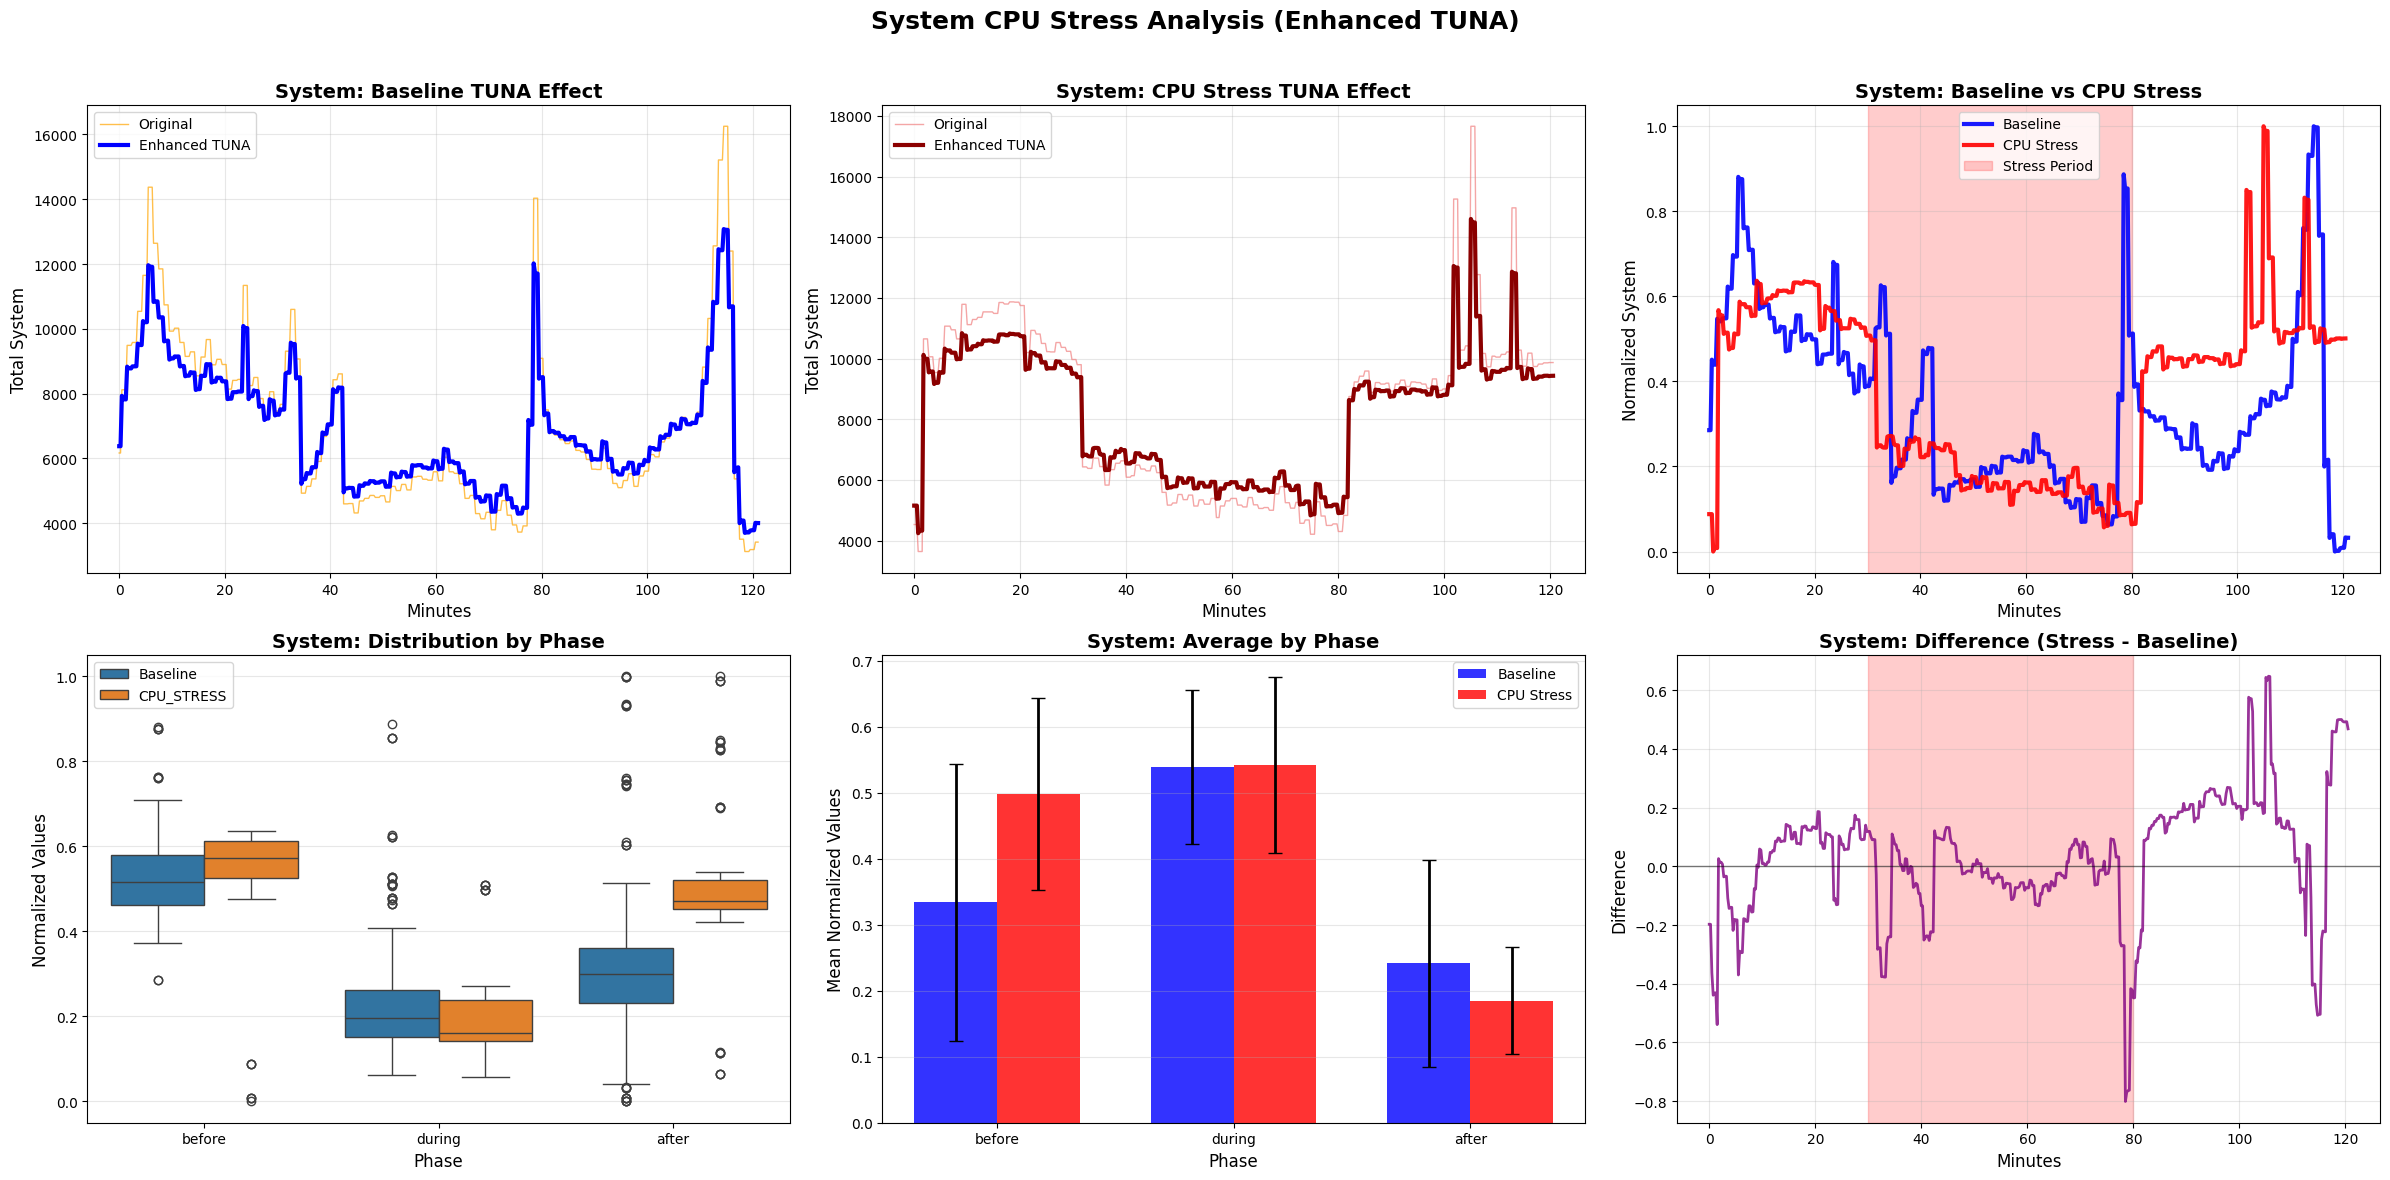

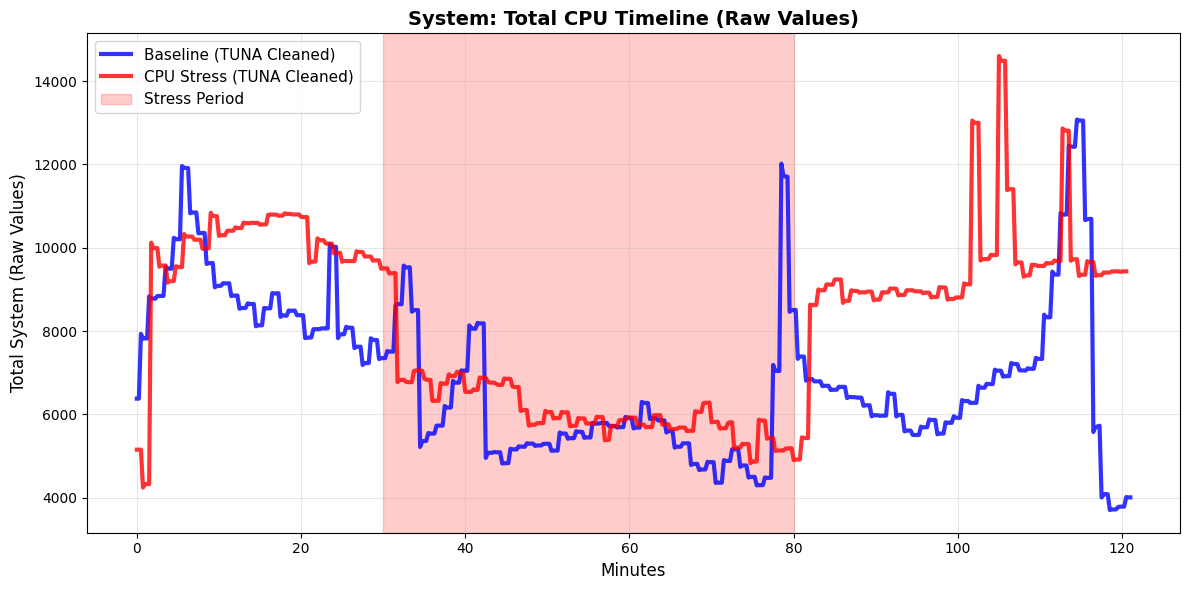


📊 System - Cumulative CPU Summary:
  🔵 Baseline Mean: 6948.13
  🔴 Stress Mean: 8161.95
  📊 Difference: +1213.82 (+17.5%)

SYSTEM - ENHANCED TUNA ANALYSIS RESULTS

🔧 ENHANCED TUNA CLEANING SUMMARY:
  CPU STRESS: 0 unstable periods, 23.9% noise reduction
  BASELINE:   0 unstable periods, 27.1% noise reduction
  METHOD:     Enhanced-TUNA-Per-Feature
  FEATURES:   8 CPU features processed
  MODELS:     8 successful noise models

📊 BASELINE STATISTICS BY PHASE:
          mean     std     min    max
phase                                
after   0.3336  0.2100  0.0000  1.000
before  0.5384  0.1164  0.2853  0.881
during  0.2413  0.1563  0.0631  0.887

📊 CPU STRESS STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.4973  0.1455  0.0646  1.0000
before  0.5419  0.1329  0.0000  0.6367
during  0.1847  0.0809  0.0568  0.5079

🔬 STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t= -0.21, p=  0.8308 (❌ NOT SIGNIFICANT)
  DURING  : t=  4.56, p=  0.00

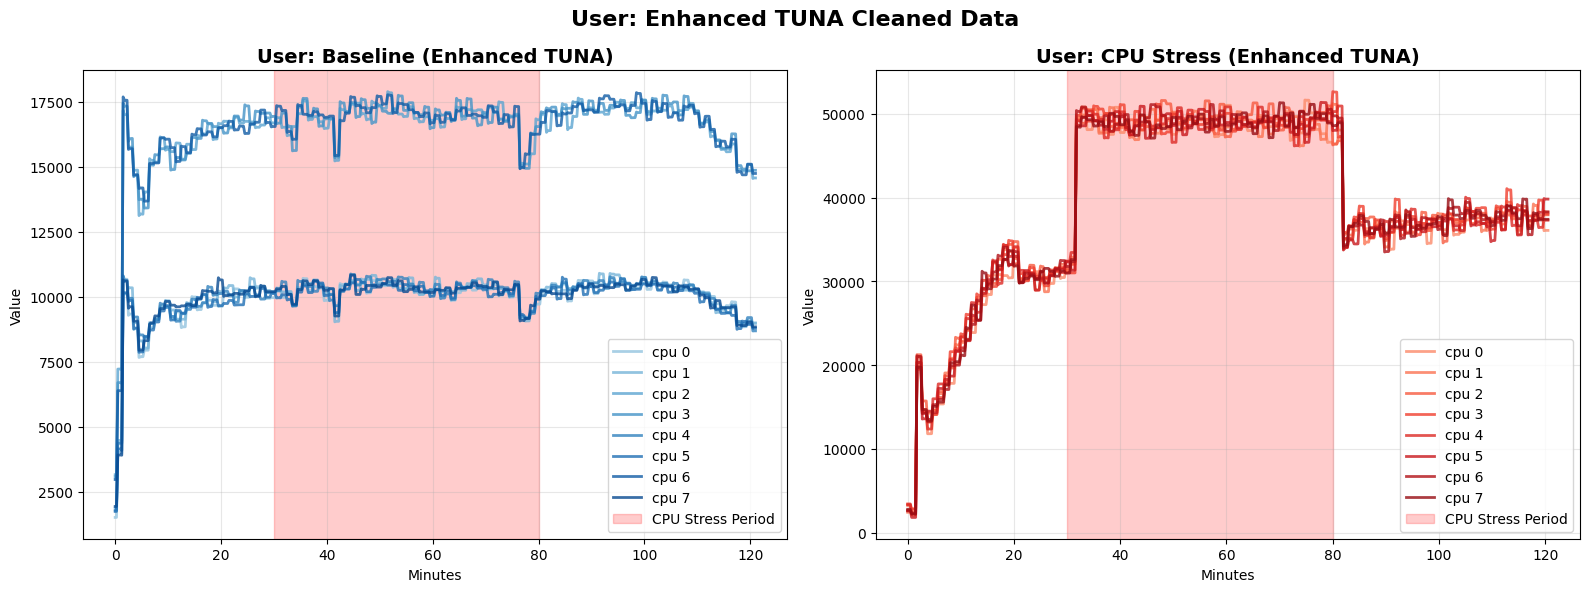

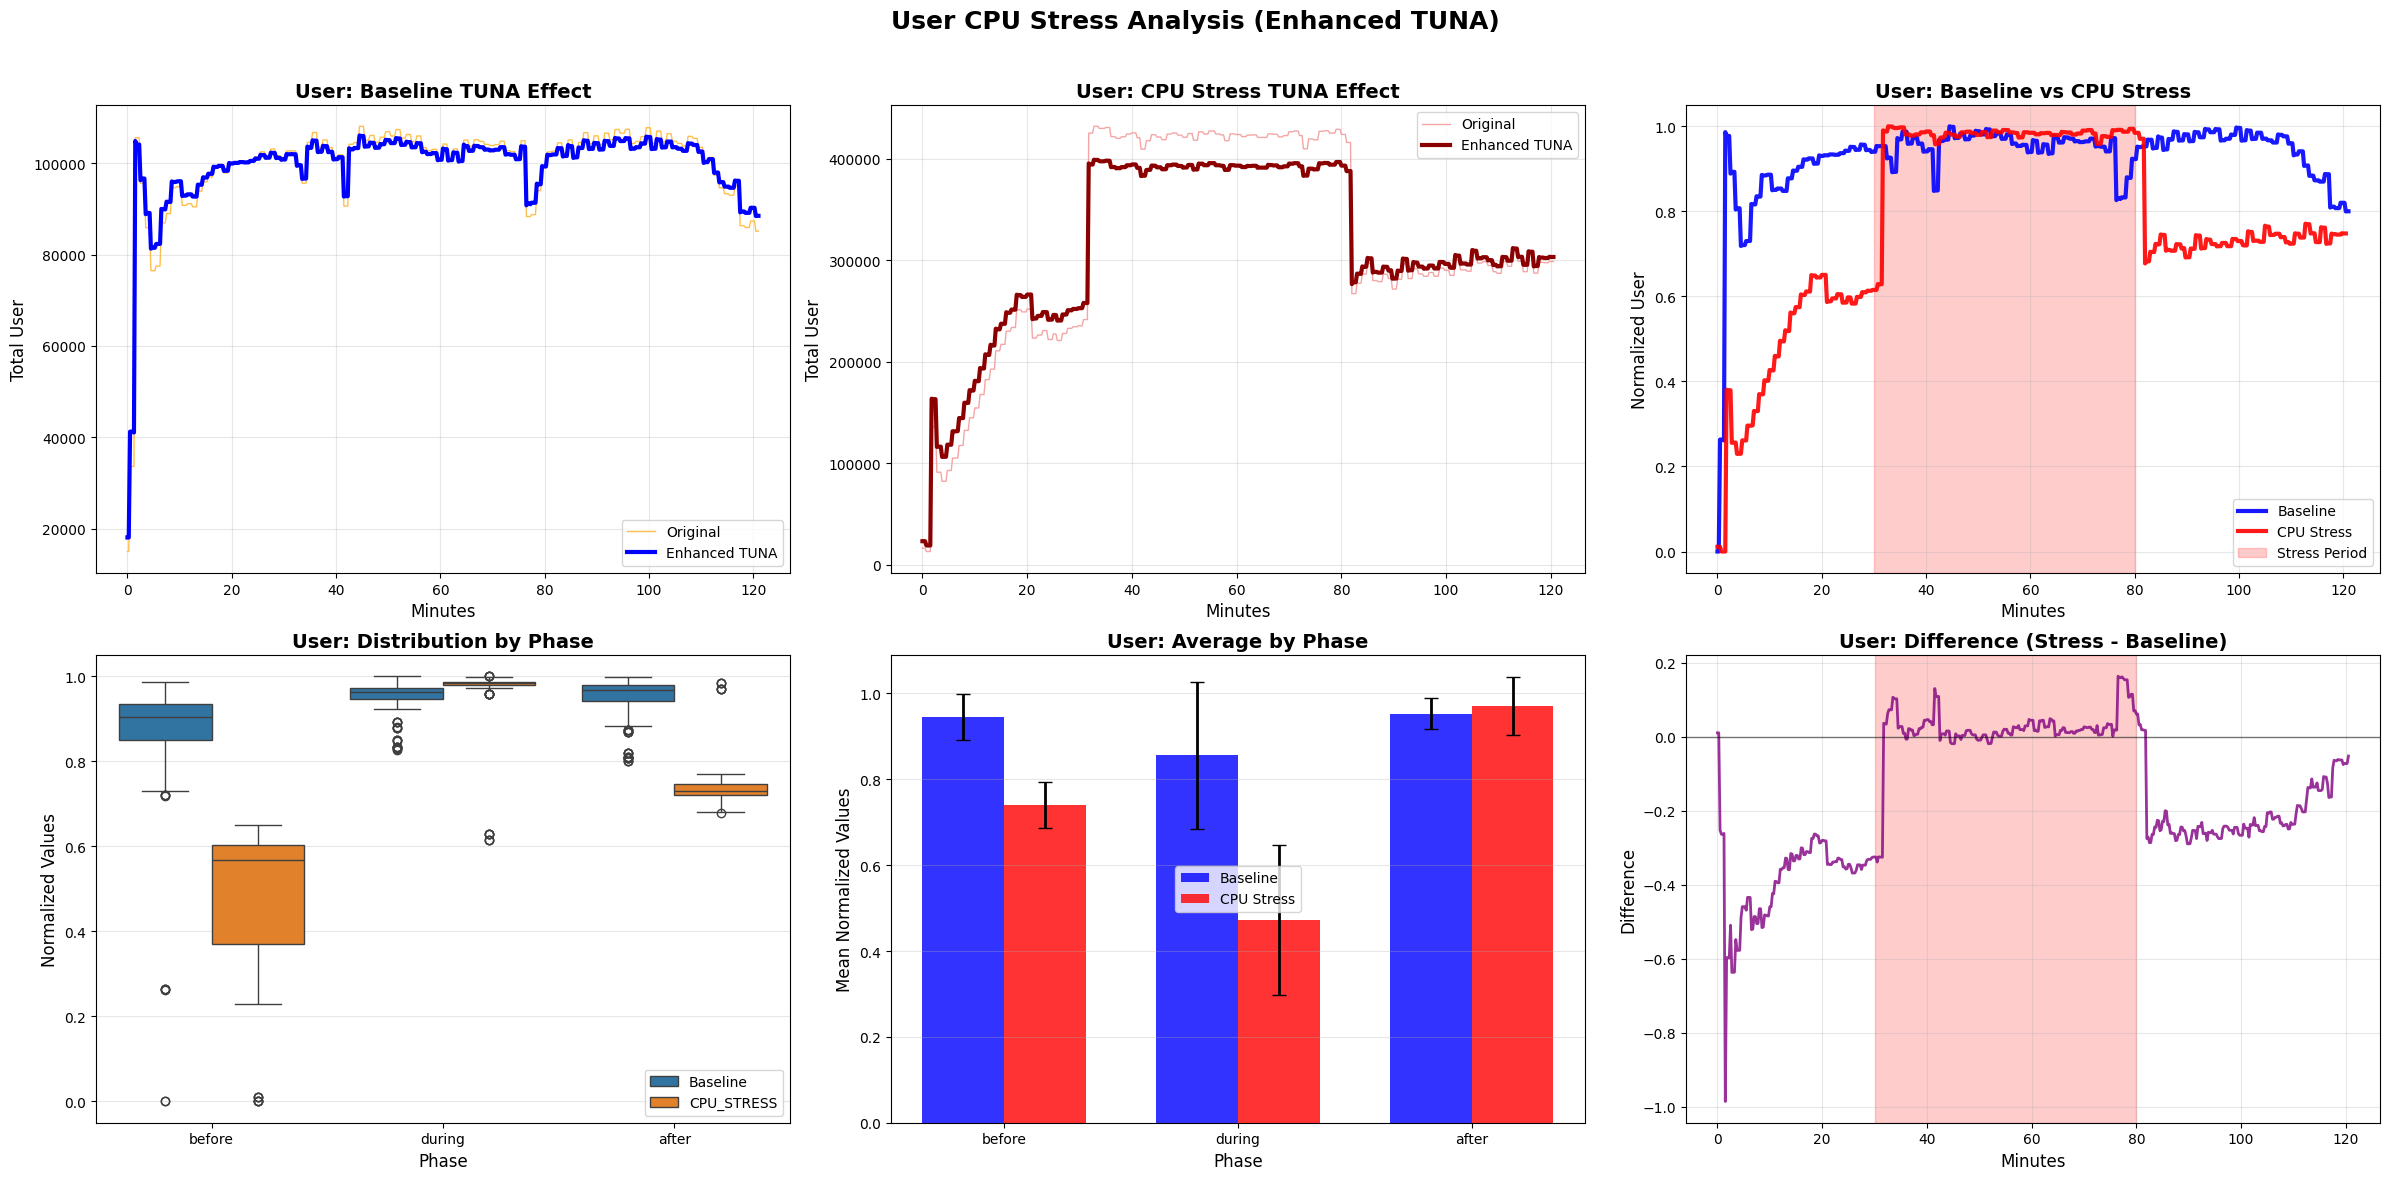

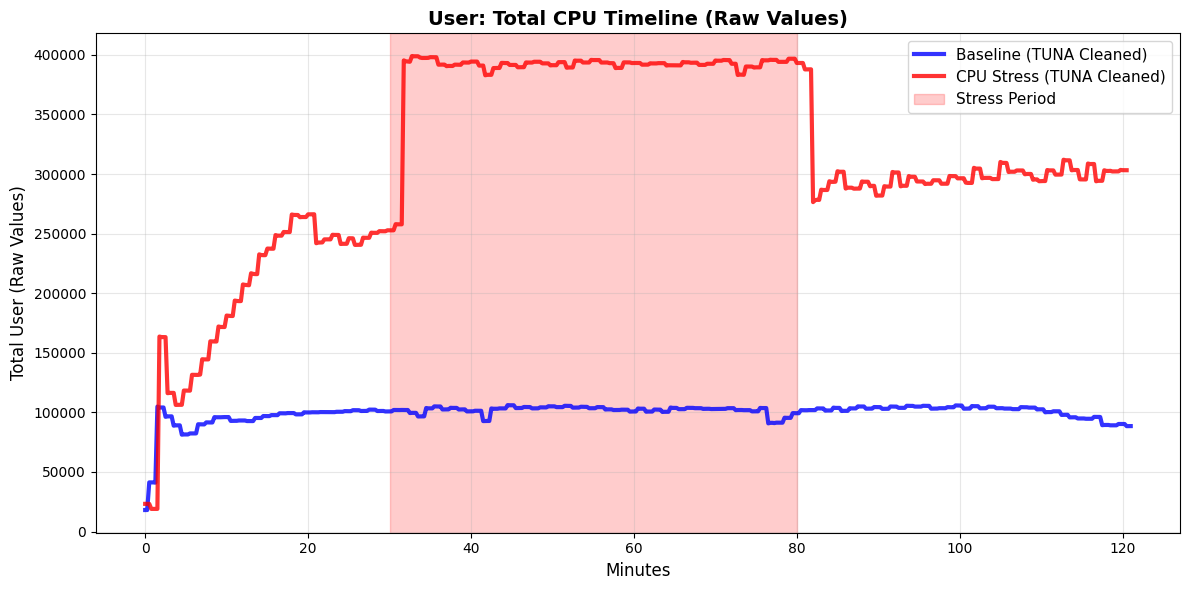


📊 User - Cumulative CPU Summary:
  🔵 Baseline Mean: 99589.05
  🔴 Stress Mean: 311658.05
  📊 Difference: +212069.00 (+212.9%)

USER - ENHANCED TUNA ANALYSIS RESULTS

🔧 ENHANCED TUNA CLEANING SUMMARY:
  CPU STRESS: 0 unstable periods, 19.3% noise reduction
  BASELINE:   0 unstable periods, 14.0% noise reduction
  METHOD:     Enhanced-TUNA-Per-Feature
  FEATURES:   8 CPU features processed
  MODELS:     8 successful noise models

📊 BASELINE STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.9450  0.0535  0.7997  0.9972
before  0.8558  0.1708  0.0000  0.9862
during  0.9530  0.0368  0.8262  1.0000

📊 CPU STRESS STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.7411  0.0535  0.6774  0.9847
before  0.4727  0.1750  0.0000  0.6506
during  0.9710  0.0668  0.6151  1.0000

🔬 STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t= 17.16, p=  0.0000 (✅ SIGNIFICANT)
  DURING  : t= -3.34, p=  0

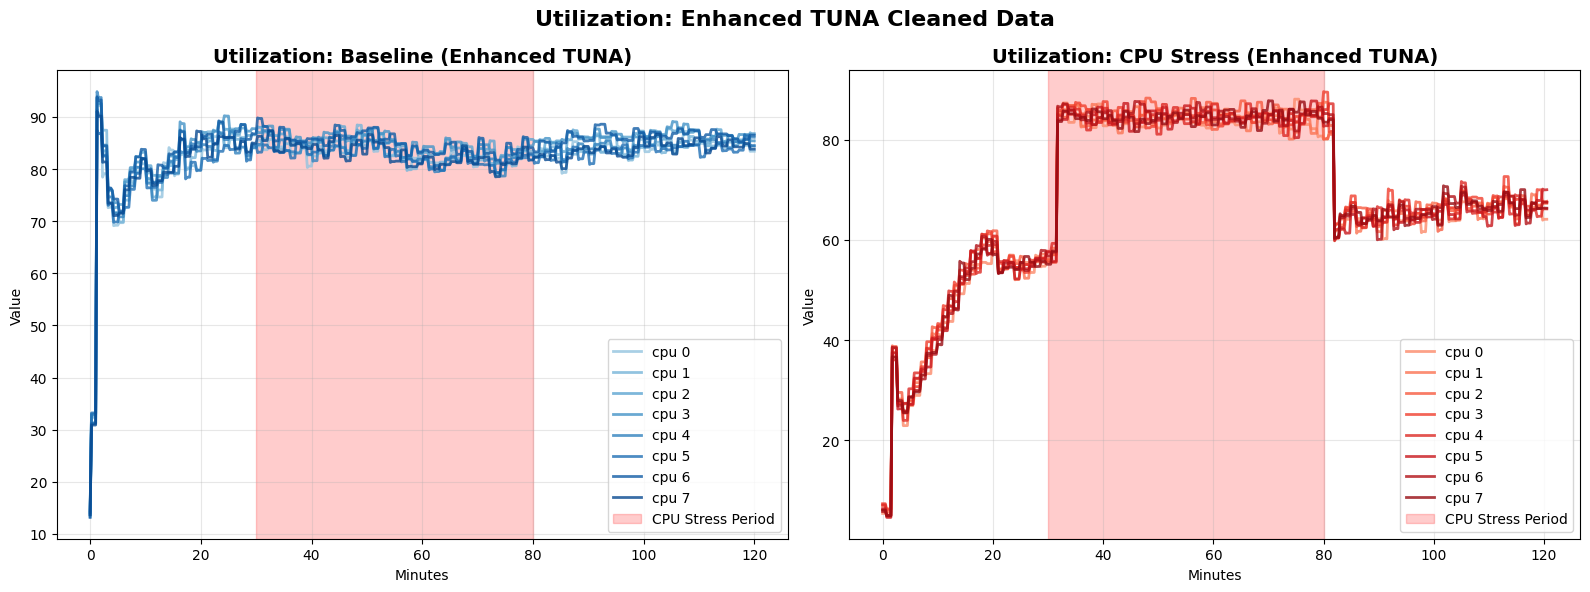

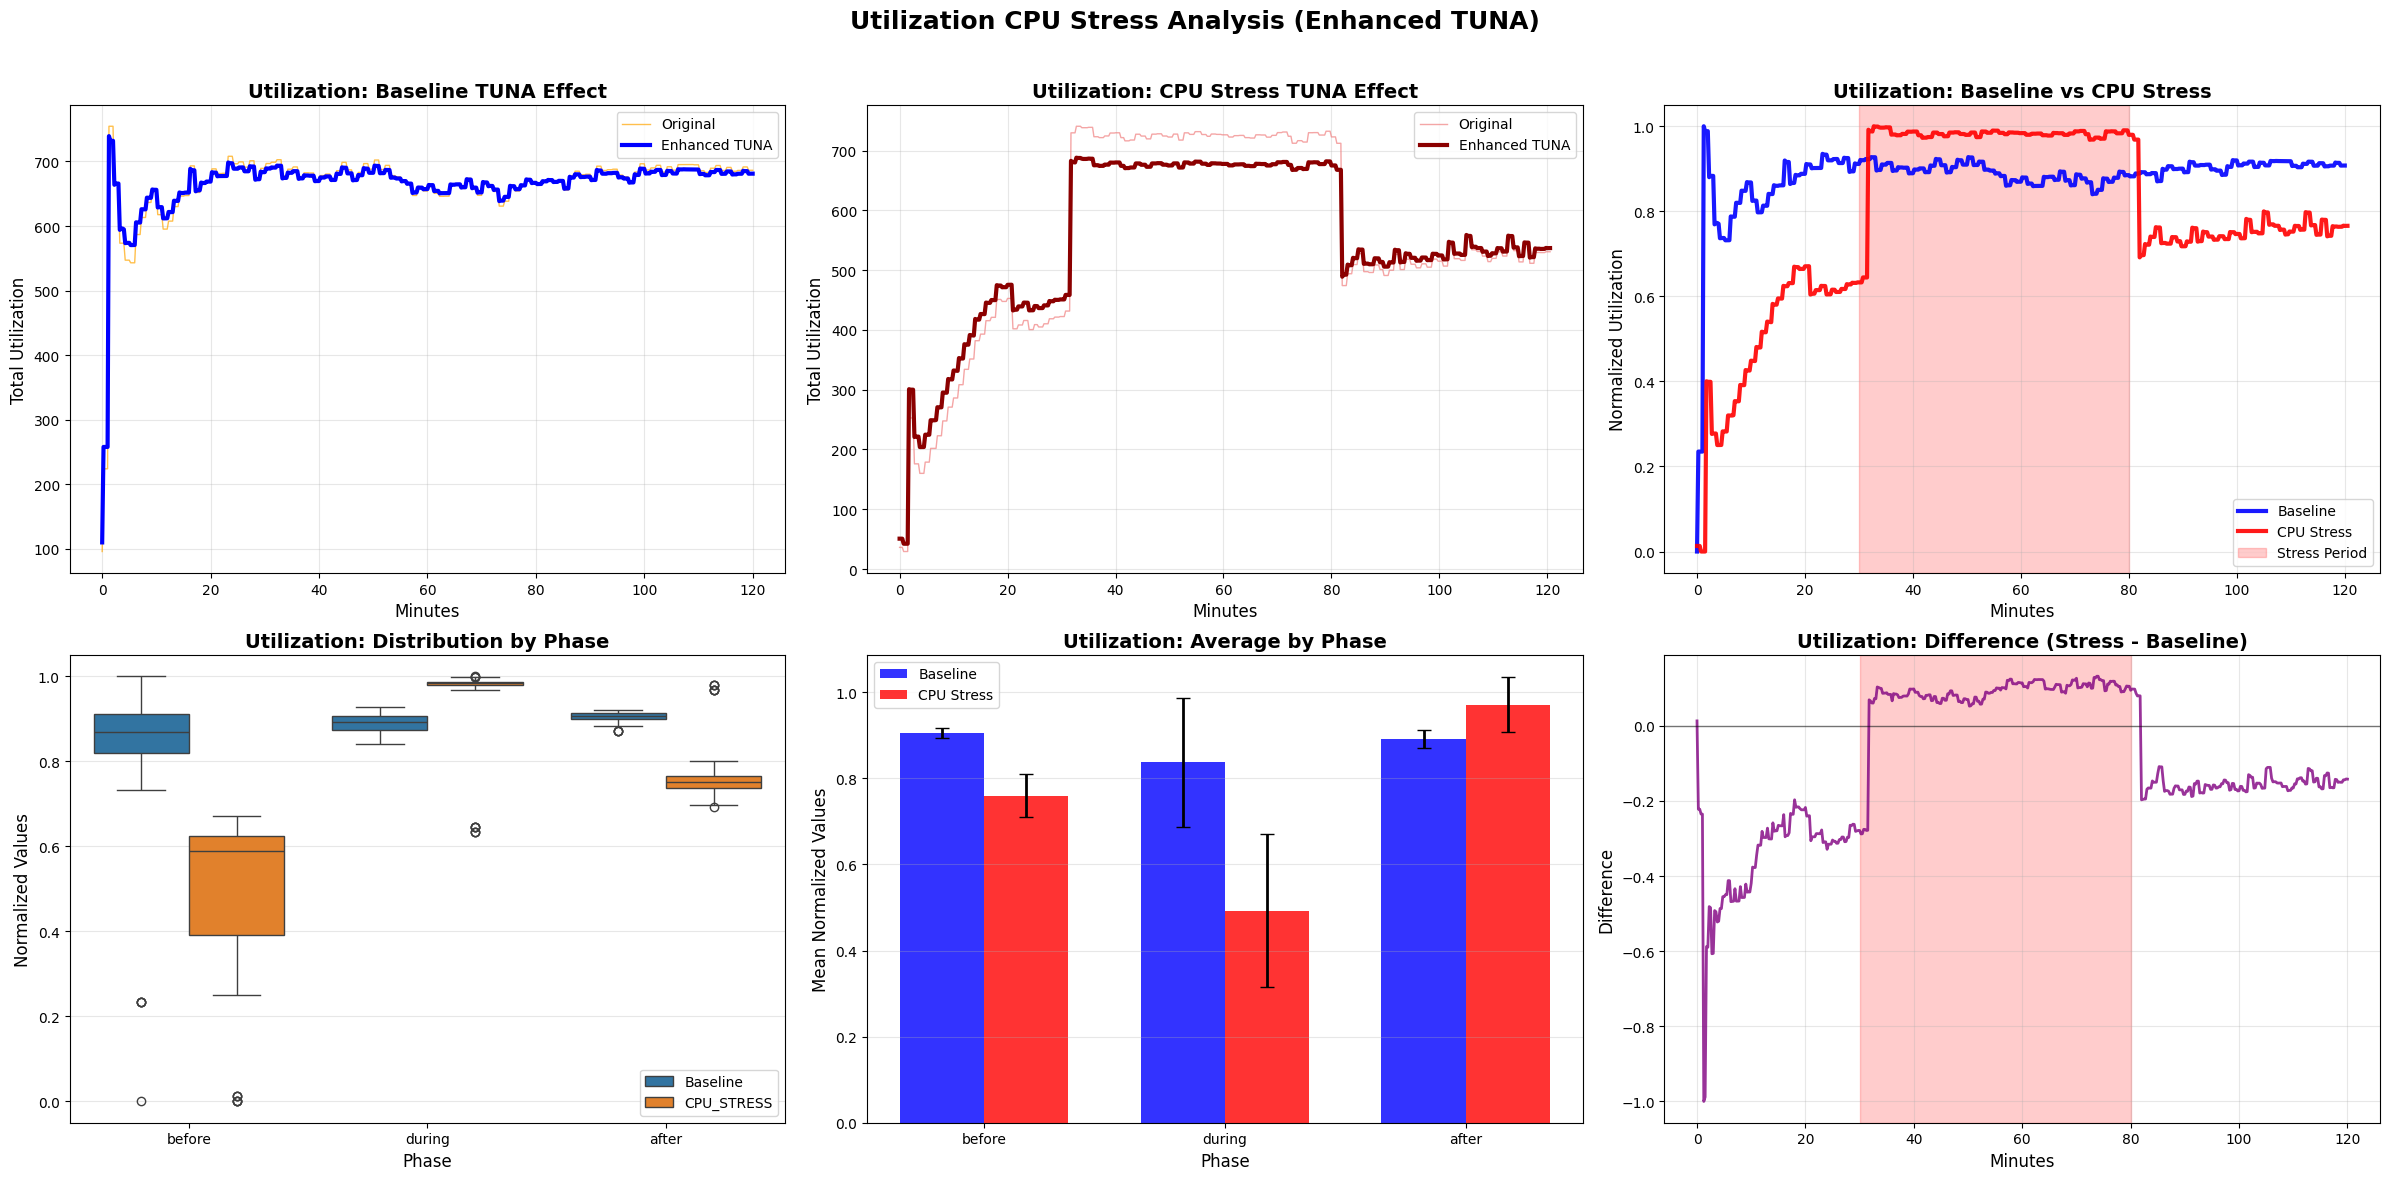

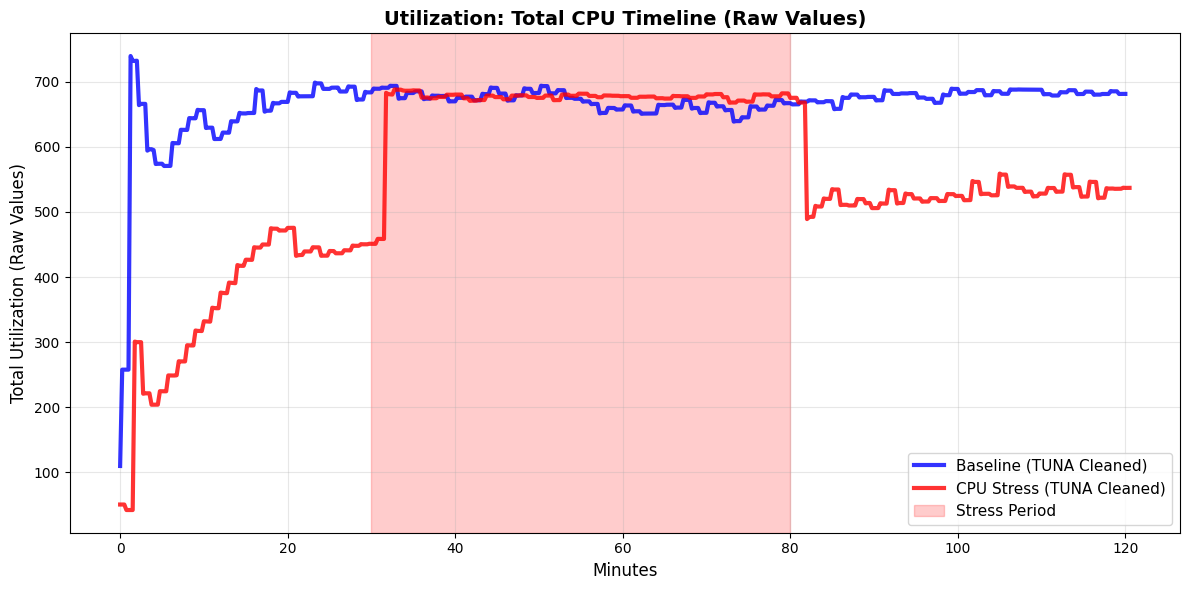


📊 Utilization - Cumulative CPU Summary:
  🔵 Baseline Mean: 664.94
  🔴 Stress Mean: 546.75
  📊 Difference: -118.19 (-17.8%)

UTILIZATION - ENHANCED TUNA ANALYSIS RESULTS

🔧 ENHANCED TUNA CLEANING SUMMARY:
  CPU STRESS: 0 unstable periods, 19.0% noise reduction
  BASELINE:   0 unstable periods, 11.2% noise reduction
  METHOD:     Enhanced-TUNA-Per-Feature
  FEATURES:   8 CPU features processed
  MODELS:     8 successful noise models

📊 BASELINE STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.9046  0.0114  0.8704  0.9204
before  0.8378  0.1497  0.0000  1.0000
during  0.8904  0.0209  0.8401  0.9275

📊 CPU STRESS STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.7592  0.0501  0.6917  0.9800
before  0.4922  0.1775  0.0000  0.6709
during  0.9714  0.0635  0.6328  1.0000

🔬 STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t= 16.30, p=  0.0000 (✅ SIGNIFICANT)
  DURING  : t=-17.18, 

In [16]:
# NORMALIZATION FUNCTION
def normalize_df(df, columns):
    result = df.copy()
    for col in columns:
        min_val = df[col].min()
        max_val = df[col].max()
        if max_val > min_val:  
            result[col] = (df[col] - min_val) / (max_val - min_val)
        else:
            result[col] = 0
    return result


# ADD PHASE COLUMN
def add_phase_column(df, delay_minutes, duration_minutes):
    df = df.copy()
    df['phase'] = 'before'  
    df.loc[(df['Minutes'] >= delay_minutes) & (df['Minutes'] <= delay_minutes + duration_minutes), 'phase'] = 'during'  
    df.loc[df['Minutes'] > delay_minutes + duration_minutes, 'phase'] = 'after' 
    return df


# PLOT INDIVIDUAL CPU COLUMNS (UPDATED)
def plot_original_data(dataset_name, cpu_stress_df, baseline_df, delay_minutes, duration_minutes):
    # Use the corrected cpu column filter
    cpu_cols = [col for col in cpu_stress_df.columns if col.startswith('cpu') and col not in ['cpu 8', 'cpu 9'] and '_' not in col]
    
    if len(cpu_cols) == 0:
        print(f"No CPU columns found in {dataset_name}")
        return
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Baseline Data
    colors_baseline = plt.cm.Blues(np.linspace(0.4, 0.9, len(cpu_cols)))
    for i, cpu_col in enumerate(cpu_cols):
        ax1.plot(baseline_df['Minutes'], baseline_df[cpu_col], 
                color=colors_baseline[i], linewidth=2, alpha=0.8, 
                label=cpu_col)
    
    ax1.axvspan(delay_minutes, delay_minutes + duration_minutes, 
                color='red', alpha=0.2, label="CPU Stress Period")
    ax1.set_title(f'{dataset_name}: Baseline (Enhanced TUNA)', fontweight='bold', fontsize=14)
    ax1.set_xlabel('Minutes')
    ax1.set_ylabel('Value')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # CPU Stress Data
    colors_stress = plt.cm.Reds(np.linspace(0.4, 0.9, len(cpu_cols)))
    for i, cpu_col in enumerate(cpu_cols):
        ax2.plot(cpu_stress_df['Minutes'], cpu_stress_df[cpu_col], 
                color=colors_stress[i], linewidth=2, alpha=0.8, 
                label=cpu_col)
    
    ax2.axvspan(delay_minutes, delay_minutes + duration_minutes, 
                color='red', alpha=0.2, label="CPU Stress Period")
    ax2.set_title(f'{dataset_name}: CPU Stress (Enhanced TUNA)', fontweight='bold', fontsize=14)
    ax2.set_xlabel('Minutes')
    ax2.set_ylabel('Value')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    plt.suptitle(f'{dataset_name}: Enhanced TUNA Cleaned Data', 
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()


# MAIN ANALYSIS FUNCTION 
def analyze_and_plot_dataset_wide(dataset_name, cpu_stress_df, baseline_df, delay_minutes, duration_minutes):
    # Use the corrected cpu column filter
    cpu_cols = [col for col in cpu_stress_df.columns if col.startswith('cpu') and col not in ['cpu 8', 'cpu 9'] and '_' not in col]
    
    print(f"\n📊 Plotting Enhanced TUNA cleaned data for {dataset_name}...")
    plot_original_data(dataset_name, cpu_stress_df, baseline_df, delay_minutes, duration_minutes)
    
    cpu_stress_norm = normalize_df(cpu_stress_df, cpu_cols)
    baseline_norm = normalize_df(baseline_df, cpu_cols)
    
    # Use TUNA-cleaned Total_CPU_TUNA if available
    if 'Total_CPU_TUNA' in cpu_stress_df.columns:
        cpu_stress_df['Total'] = cpu_stress_df['Total_CPU_TUNA']
        baseline_df['Total'] = baseline_df['Total_CPU_TUNA']
    else:
        cpu_stress_df['Total'] = cpu_stress_df[cpu_cols].sum(axis=1)
        baseline_df['Total'] = baseline_df[cpu_cols].sum(axis=1)
    
    # Normalize totals (with safe division)
    cpu_stress_range = cpu_stress_df['Total'].max() - cpu_stress_df['Total'].min()
    baseline_range = baseline_df['Total'].max() - baseline_df['Total'].min()
    
    if cpu_stress_range > 0:
        cpu_stress_norm['Total'] = (cpu_stress_df['Total'] - cpu_stress_df['Total'].min()) / cpu_stress_range
    else:
        cpu_stress_norm['Total'] = 0
        
    if baseline_range > 0:
        baseline_norm['Total'] = (baseline_df['Total'] - baseline_df['Total'].min()) / baseline_range
    else:
        baseline_norm['Total'] = 0
    
    # Add phase information
    cpu_stress_norm = add_phase_column(cpu_stress_norm, delay_minutes, duration_minutes)
    baseline_norm = add_phase_column(baseline_norm, delay_minutes, duration_minutes)
    
    # Statistical analysis
    stats_baseline = baseline_norm.groupby('phase')['Total'].agg(['mean', 'std', 'min', 'max'])
    stats_cpu_stress = cpu_stress_norm.groupby('phase')['Total'].agg(['mean', 'std', 'min', 'max'])
    
    # Combined dataframe for analysis
    df_combined = pd.DataFrame({
        'Baseline': baseline_norm['Total'],
        'CPU_STRESS': cpu_stress_norm['Total'],
        'Minutes': baseline_norm['Minutes'],
        'phase': baseline_norm['phase'],
        'difference': cpu_stress_norm['Total'] - baseline_norm['Total']
    })
    
    # T-tests for statistical significance
    t_tests = {}
    for phase in ['before', 'during', 'after']:
        data = df_combined[df_combined['phase'] == phase]
        t_stat, p_value = scipy_stats.ttest_ind(data['Baseline'].dropna(), data['CPU_STRESS'].dropna())
        t_tests[phase] = {'t': t_stat, 'p': p_value}
    
    # Calculate percentage impact
    impact = {}
    for phase in ['before', 'during', 'after']:
        baseline_mean = stats_baseline.loc[phase, 'mean']
        cpu_stress_mean = stats_cpu_stress.loc[phase, 'mean']
        impact[phase] = ((cpu_stress_mean - baseline_mean) / baseline_mean) * 100 if baseline_mean != 0 else float('inf')
    
    # COMPARISON PLOTS
    fig = plt.figure(figsize=(24, 12))
    
    # 1. Baseline TUNA effect
    plt.subplot(2, 3, 1)
    original_baseline = original_datasets[dataset_name]['baseline']
    
    plt.plot(original_baseline['Minutes'], original_baseline[cpu_cols].sum(axis=1), 
             label='Original', color='orange', alpha=0.7, linewidth=1)
    plt.plot(baseline_df['Minutes'], baseline_df['Total'], 
             label='Enhanced TUNA', linewidth=3, color='blue')
    plt.title(f'{dataset_name}: Baseline TUNA Effect', fontsize=14, fontweight='bold')
    plt.xlabel('Minutes', fontsize=12)
    plt.ylabel(f'Total {dataset_name}', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # 2. CPU STRESS TUNA effect
    plt.subplot(2, 3, 2)
    original_cpu_stress = original_datasets[dataset_name]['cpu_stress']
    
    plt.plot(original_cpu_stress['Minutes'], original_cpu_stress[cpu_cols].sum(axis=1), 
             label='Original', alpha=0.7, color='lightcoral', linewidth=1)
    plt.plot(cpu_stress_df['Minutes'], cpu_stress_df['Total'], 
             label='Enhanced TUNA', linewidth=3, color='darkred')
    plt.title(f'{dataset_name}: CPU Stress TUNA Effect', fontsize=14, fontweight='bold')
    plt.xlabel('Minutes', fontsize=12)
    plt.ylabel(f'Total {dataset_name}', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # 3. Timeline comparison
    plt.subplot(2, 3, 3)
    plt.plot(baseline_norm['Minutes'], baseline_norm['Total'], 
             label='Baseline', linewidth=3, color='blue', alpha=0.9)
    plt.plot(cpu_stress_norm['Minutes'], cpu_stress_norm['Total'], 
             label='CPU Stress', linewidth=3, color='red', alpha=0.9)
    plt.axvspan(delay_minutes, delay_minutes + duration_minutes, 
                color='red', alpha=0.2, label="Stress Period")
    plt.title(f"{dataset_name}: Baseline vs CPU Stress", fontsize=14, fontweight='bold')
    plt.xlabel("Minutes", fontsize=12)
    plt.ylabel(f"Normalized {dataset_name}", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=10)
    
    # 4. Box plot by phase
    plt.subplot(2, 3, 4)
    box_data = pd.melt(df_combined[['Baseline', 'CPU_STRESS', 'phase']], 
                      id_vars=['phase'], var_name='source', value_name='value')
    sns.boxplot(x='phase', y='value', hue='source', data=box_data, ax=plt.gca())
    plt.title(f'{dataset_name}: Distribution by Phase', fontsize=14, fontweight='bold')
    plt.xlabel('Phase', fontsize=12)
    plt.ylabel('Normalized Values', fontsize=12)
    plt.grid(axis='y', alpha=0.3)
    plt.legend(fontsize=10)
    
    # 5. Statistics by phase
    plt.subplot(2, 3, 5)
    phases = ['before', 'during', 'after']
    x = np.arange(len(phases))
    width = 0.35
    
    bars1 = plt.bar(x - width/2, stats_baseline['mean'], width, label='Baseline', alpha=0.8, color='blue')
    bars2 = plt.bar(x + width/2, stats_cpu_stress['mean'], width, label='CPU Stress', alpha=0.8, color='red')
    
    plt.errorbar(x - width/2, stats_baseline['mean'], yerr=stats_baseline['std'], 
                fmt='none', ecolor='black', capsize=5, linewidth=2)
    plt.errorbar(x + width/2, stats_cpu_stress['mean'], yerr=stats_cpu_stress['std'], 
                fmt='none', ecolor='black', capsize=5, linewidth=2)
    
    plt.title(f'{dataset_name}: Average by Phase', fontsize=14, fontweight='bold')
    plt.xlabel('Phase', fontsize=12)
    plt.ylabel('Mean Normalized Values', fontsize=12)
    plt.xticks(x, phases)
    plt.legend(fontsize=10)
    plt.grid(axis='y', alpha=0.3)
    
    # 6. Difference over time
    plt.subplot(2, 3, 6)
    plt.plot(df_combined['Minutes'], df_combined['difference'], 
             color='purple', linewidth=2, alpha=0.8)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.5, linewidth=1)
    plt.axvspan(delay_minutes, delay_minutes + duration_minutes, 
                color='red', alpha=0.2)
    plt.title(f'{dataset_name}: Difference (Stress - Baseline)', fontsize=14, fontweight='bold')
    plt.xlabel('Minutes', fontsize=12)
    plt.ylabel('Difference', fontsize=12)
    plt.grid(True, alpha=0.3)
    
    plt.suptitle(f'{dataset_name} CPU Stress Analysis (Enhanced TUNA)', 
                fontsize=18, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.subplots_adjust(top=0.90)
    plt.show()

    plot_cumulative_cpu_raw(dataset_name, cpu_stress_clean, baseline_clean, delay, duration)
    
    # Print results
    print(f"\n{'='*80}")
    print(f"{dataset_name.upper()} - ENHANCED TUNA ANALYSIS RESULTS")
    print(f"{'='*80}")
    
    cpu_stress_stats = all_outlier_stats[dataset_name]['cpu_stress']['_summary']
    baseline_stats = all_outlier_stats[dataset_name]['baseline']['_summary']
    
    print(f"\n🔧 ENHANCED TUNA CLEANING SUMMARY:")
    print(f"  CPU STRESS: {cpu_stress_stats['total_outliers']} unstable periods, {cpu_stress_stats['noise_reduction']:.1f}% noise reduction")
    print(f"  BASELINE:   {baseline_stats['total_outliers']} unstable periods, {baseline_stats['noise_reduction']:.1f}% noise reduction")
    print(f"  METHOD:     {cpu_stress_stats['method']}")
    print(f"  FEATURES:   {cpu_stress_stats['total_features_processed']} CPU features processed")
    print(f"  MODELS:     {cpu_stress_stats['successful_noise_models']} successful noise models")
    
    print(f"\n📊 BASELINE STATISTICS BY PHASE:")
    print(stats_baseline.round(4))
    
    print(f"\n📊 CPU STRESS STATISTICS BY PHASE:")
    print(stats_cpu_stress.round(4))
    
    print(f"\n🔬 STATISTICAL SIGNIFICANCE TESTS:")
    for phase, test in t_tests.items():
        sig = "✅ SIGNIFICANT" if test['p'] < 0.05 else "❌ NOT SIGNIFICANT"
        print(f"  {phase.upper():8}: t={test['t']:6.2f}, p={test['p']:8.4f} ({sig})")
    
    print(f"\n📈 CPU STRESS IMPACT (% CHANGE):")
    for phase, change in impact.items():
        direction = "↗️ INCREASE" if change > 0 else "↘️ DECREASE" if change < 0 else "→ NO CHANGE"
        print(f"  {phase.upper():8}: {change:+7.2f}% ({direction})")
    
    return {
        'stats_baseline': stats_baseline,
        'stats_cpu_stress': stats_cpu_stress,
        't_tests': t_tests,
        'impact': impact,
        'combined_data': df_combined,
        'cpu_columns': cpu_cols
    }

def plot_cumulative_cpu_raw(dataset_name, cpu_stress_df, baseline_df, delay_minutes, duration_minutes):
    """
    Plot only cumulative CPU timeline (raw values, not normalized)
    """
    
    # Get total CPU values
    stress_total = cpu_stress_df['Total_CPU_TUNA'] if 'Total_CPU_TUNA' in cpu_stress_df.columns else cpu_stress_df[[col for col in cpu_stress_df.columns if col.startswith('cpu') and col not in ['cpu 8', 'cpu 9'] and '_' not in col]].sum(axis=1)
    baseline_total = baseline_df['Total_CPU_TUNA'] if 'Total_CPU_TUNA' in baseline_df.columns else baseline_df[[col for col in baseline_df.columns if col.startswith('cpu') and col not in ['cpu 8', 'cpu 9'] and '_' not in col]].sum(axis=1)
    
    # Single plot
    plt.figure(figsize=(12, 6))
    
    plt.plot(baseline_df['Minutes'], baseline_total, 
             label='Baseline (TUNA Cleaned)', linewidth=3, color='blue', alpha=0.8)
    plt.plot(cpu_stress_df['Minutes'], stress_total, 
             label='CPU Stress (TUNA Cleaned)', linewidth=3, color='red', alpha=0.8)
    
    plt.axvspan(delay_minutes, delay_minutes + duration_minutes, 
                color='red', alpha=0.2, label="Stress Period")
    
    plt.title(f'{dataset_name}: Total CPU Timeline (Raw Values)', fontweight='bold', fontsize=14)
    plt.xlabel('Minutes', fontsize=12)
    plt.ylabel(f'Total {dataset_name} (Raw Values)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=11)
    
    plt.tight_layout()
    plt.show()
    
    # Print simple summary
    baseline_mean = baseline_total.mean()
    stress_mean = stress_total.mean()
    difference = stress_mean - baseline_mean
    percent_change = (difference / baseline_mean) * 100 if baseline_mean != 0 else 0
    
    print(f"\n📊 {dataset_name} - Cumulative CPU Summary:")
    print(f"  🔵 Baseline Mean: {baseline_mean:.2f}")
    print(f"  🔴 Stress Mean: {stress_mean:.2f}")
    print(f"  📊 Difference: {difference:+.2f} ({percent_change:+.1f}%)")


# RUN ANALYSIS (FIXED)
print(f"\n{'='*80}")
print("COMPREHENSIVE CPU STRESS ANALYSIS - ENHANCED TUNA")
print(f"{'='*80}")

analysis_results = {}

for dataset_name in datasets_clean.keys():
    print(f"\n🔄 Analyzing {dataset_name}...")
    
    cpu_stress_clean = datasets_clean[dataset_name]['cpu_stress']
    baseline_clean = datasets_clean[dataset_name]['baseline']
    
    analysis_results[dataset_name] = analyze_and_plot_dataset_wide(
        dataset_name, 
        cpu_stress_clean, 
        baseline_clean, 
        delay, 
        duration
    )